## Digit Recognizer
https://www.kaggle.com/c/digit-recognizer

In [1]:
#!pip install opencv-python

In [2]:
%matplotlib inline
import cv2
import numpy as np
import matplotlib.pyplot as plt

## Загружаем исходные данные

In [3]:
train = np.loadtxt('./data/digit/train.csv', delimiter=',', skiprows=1)
test = np.loadtxt('./data/digit/test.csv', delimiter=',', skiprows=1)

In [4]:
# сохраняем разметку в отдельную переменную
train_label = train[:, 0]
# приводим размерность к удобному для обаботки виду
train_img = np.resize(train[:, 1:], (train.shape[0], 28, 28))
test_img = np.resize(test, (test.shape[0], 28, 28))

In [5]:
train_img.shape

(42000, 28, 28)

## Визуализируем исходные данные

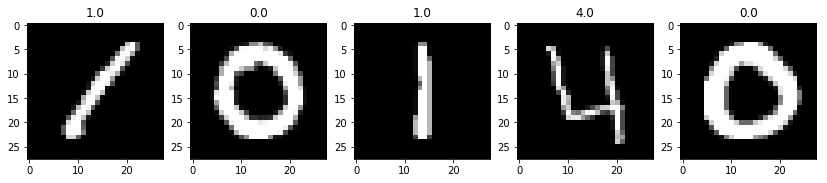

In [6]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(train_img[0:5], 1):
    subplot = fig.add_subplot(1, 7, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % train_label[i - 1]);

## Попробуем разбить на части. Интересно, как разбиение на 2, 3 и 4 части повлияют на результат.

In [7]:
def cutting_pictures_3(imgs):
    train_img_cutt = []
    for i, img in enumerate(imgs):
        f1 = img[:9, :]
        f2 = img[9:18, :]
        f3 = img[18:27, :]             
        f = np.append(f1,f2, axis=1)
        f = np.append(f,f3, axis=1)
        train_img_cutt.append(f)
    return train_img_cutt

In [8]:
def cutting_pictures_4(imgs):
    train_img_cutt = []
    for i, img in enumerate(imgs):
        f1 = img[:7, :]
        f2 = img[7:14, :]
        f3 = img[14:21, :]   
        f4 = img[21:, :]           
        f = np.append(f1,f2, axis=1)
        f = np.append(f,f3, axis=1)
        f = np.append(f,f4, axis=1)
        train_img_cutt.append(f)
    return train_img_cutt


In [9]:
def cutting_pictures_2(imgs):
    train_img_cutt = []
    for i, img in enumerate(imgs):
        f1 = img[:14, :]
        f2 = img[14:, :]   
        f = np.append(f1,f2, axis=1)
        train_img_cutt.append(f)
    return train_img_cutt

In [10]:


train_img_cutt_4 = cutting_pictures_4(train_img)
test_img_cutt_4 = cutting_pictures_4(test_img)

train_img_cutt_3 = cutting_pictures_3(train_img)
test_img_cutt_3 = cutting_pictures_3(test_img)

train_img_cutt_2 = cutting_pictures_2(train_img)
test_img_cutt_2 = cutting_pictures_2(test_img)


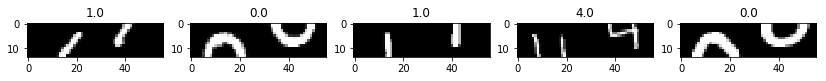

In [11]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(train_img_cutt_2[0:5], 1):
    subplot = fig.add_subplot(1, 7, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % train_label[i - 1]);

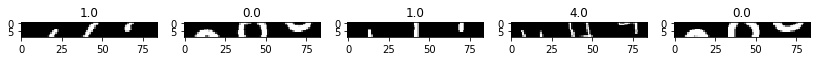

In [12]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(train_img_cutt_3[0:5], 1):
    subplot = fig.add_subplot(1, 7, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % train_label[i - 1]);

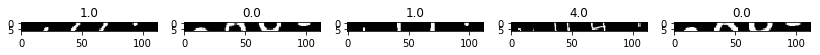

In [13]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(train_img_cutt_4[0:5], 1):
    subplot = fig.add_subplot(1, 7, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % train_label[i - 1]);

In [110]:
train_img_cutt = train_img_cutt_4
test_img_cutt = test_img_cutt_4
NUMBER_CUT = 4

## Вычисляем X и Y составляющие градиента с помощью оператора Собеля

In [111]:
train_sobel_x = np.zeros_like(train_img_cutt)
train_sobel_y = np.zeros_like(train_img_cutt)
for i in range(len(train_img_cutt)):
    train_sobel_x[i] = cv2.Sobel(train_img_cutt[i], cv2.CV_64F, dx=1, dy=0, ksize=3)
    train_sobel_y[i] = cv2.Sobel(train_img_cutt[i], cv2.CV_64F, dx=0, dy=1, ksize=3)

In [112]:
test_sobel_x = np.zeros_like(test_img_cutt)
test_sobel_y = np.zeros_like(test_img_cutt)
for i in range(len(test_img_cutt)):
    test_sobel_x[i] = cv2.Sobel(test_img_cutt[i], cv2.CV_64F, dx=1, dy=0, ksize=3)
    test_sobel_y[i] = cv2.Sobel(test_img_cutt[i], cv2.CV_64F, dx=0, dy=1, ksize=3)

## Вычисляем угол и длину вектора градиента

In [113]:
train_g, train_theta = cv2.cartToPolar(train_sobel_x, train_sobel_y)

In [114]:
test_g, test_theta = cv2.cartToPolar(test_sobel_x, test_sobel_y)

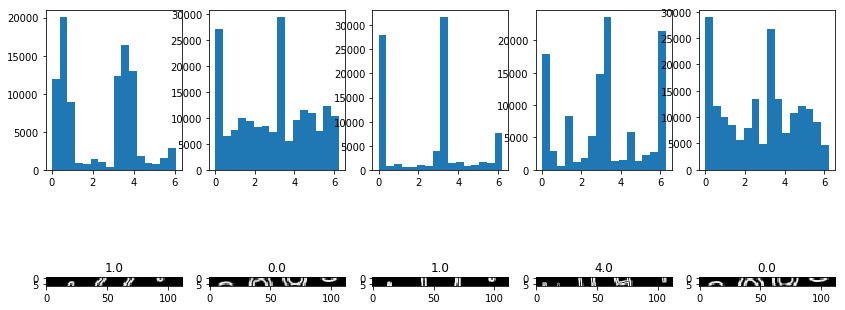

In [115]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(train_g[:5], 1):
    subplot = fig.add_subplot(1, 7, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % train_label[i - 1]);
    subplot = fig.add_subplot(3, 7, i)
    plt.hist(train_theta[i - 1].flatten(),
             bins=16, weights=train_g[i - 1].flatten())

## Вычисляем гистограммы градиентов

In [116]:
# Гистограммы вычисляются с учетом длины вектора градиента

In [117]:
def get_hist(theta,g):
    hist, borders = np.histogram(theta,
                                 bins=16,
                                 range=(0., 2. * np.pi),
                                 weights=g) 
    return hist
        

In [118]:
NUMBER_CUT

4

In [119]:
def calc_hist(image,theta,g):
    if NUMBER_CUT   == 2:
        IterCount = 3
        HSize = 14
        Z = 48
    elif NUMBER_CUT == 3:
        IterCount = 8
        HSize = 9
        Z = 128
    elif NUMBER_CUT == 4:
        IterCount = 15  
        HSize = 7
        Z = 240
        
    result_hist = np.zeros((len(image), Z))
    for i in range(len(image)):
        hist = []
        for j in range(IterCount):
            n1 = j*HSize
            n2 = (j+1)*HSize
            hist = np.append(hist,get_hist(theta[i,:, n1:n2],g[i,:, n1:n2])) 
        result_hist[i] = hist
    return result_hist   

In [122]:
train_hist = calc_hist(train_img, train_theta, train_g)
test_hist = calc_hist(test_img, test_theta, test_g)

## Нормируем вектор гистограммы

In [123]:
# По умолчанию используется L2 норма
train_hist = train_hist / np.linalg.norm(train_hist, axis=1)[:, None]

In [124]:
test_hist = test_hist / np.linalg.norm(test_hist, axis=1)[:, None]

## Разбиваем выборку на обучение и валидацию

In [125]:
from sklearn.model_selection import train_test_split
y_train, y_val, x_train, x_val = train_test_split(
    train_label, train_hist, test_size=0.2,
    random_state=42)

## Вычисляем центроиды каждого из 10 классов

In [126]:
centroids = np.zeros((10, train_hist.shape[1]), dtype=np.float32)

In [127]:
for i in range(10):
    centroids[i] = np.mean(x_train[y_train == i], axis=0)

## Находим ближайший центройд для валидации

In [128]:
pred_val = np.zeros_like(y_val)
for i in range(len(y_val)):
    distances = np.linalg.norm(centroids - x_val[i], axis=1)
    pred_val[i] = np.argmin(distances)

## Оцениваем качество решение на валидационной выборке

In [129]:
from sklearn.metrics import accuracy_score
print('Accuracy: %s' % accuracy_score(y_val, pred_val))

Accuracy: 0.8667857142857143


In [130]:
from sklearn.metrics import classification_report
print(classification_report(y_val, pred_val))

             precision    recall  f1-score   support

        0.0       0.87      0.88      0.87       816
        1.0       0.82      0.93      0.87       909
        2.0       0.89      0.87      0.88       846
        3.0       0.92      0.88      0.90       937
        4.0       0.90      0.86      0.88       839
        5.0       0.92      0.88      0.90       702
        6.0       0.87      0.87      0.87       785
        7.0       0.90      0.82      0.86       893
        8.0       0.82      0.85      0.84       835
        9.0       0.79      0.82      0.80       838

avg / total       0.87      0.87      0.87      8400



In [131]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_val, pred_val))

[[719  17   6   0   1   2  55   0  15   1]
 [  0 841  18   0   1   0   2   0  45   2]
 [ 12  23 740  10   7   0  13  13  23   5]
 [  6   5  23 828   1  29   1  10  23  11]
 [  5  25   4   0 721   1   6   5  12  60]
 [  3   1   0  39   1 621  10   1  18   8]
 [ 54  26   0   0   6   3 685   0  11   0]
 [  5  39  27   2   3   1   0 730   2  84]
 [ 12  37  11  17   7  15  11   5 712   8]
 [ 12  17   4   7  52   4   1  50   7 684]]


## Предсказания на тестовыйх данных

In [132]:
pred_test = np.zeros(len(test_img), np.uint8)
for i in range(len(test_img)):
    distances = np.linalg.norm(centroids - test_hist[i], axis=1)
    pred_test[i] = np.argmin(distances)

## Визуализируем предсказания

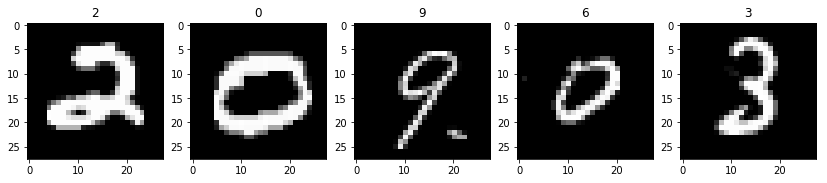

In [133]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(test_img[0:5], 1):
    subplot = fig.add_subplot(1, 7, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % pred_test[i - 1]);

## Готовим файл для отправки

In [134]:
FILE_NAME = 'submit' + str(NUMBER_CUT) + '.txt'
with open(FILE_NAME, 'w') as dst:
    dst.write('ImageId,Label\n')
    for i, p in enumerate(pred_test, 1):
        dst.write('%s,%s\n' % (i, p))

In [135]:
!head submit.txt

ImageId,Label
1,2
2,0
3,9
4,2
5,3
6,7
7,0
8,3
9,0


#### NUMBER_CUT = 2 Your submission scored 0.77614

#### NUMBER_CUT = 3 Your submission scored 0.81185

#### NUMBER_CUT = 4 Your submission scored 0.86542

#### Лучше всех показало себя разбиение на 4 части.

![Скрин с сайта https://www.kaggle.com/c/digit-recognizer](Kaggle.png)